# Topic Classification with a Feedforward Network


### 


The goal of this task is to develop a Feedforward neural network for topic classification. 



For that purpose, you will implement:

- Text processing methods for transforming raw text data into input vectors for your network  


- A Feedforward network consisting of:
    - **One-hot** input layer mapping words into an **Embedding weight matrix** 
    - **One hidden layer** computing the mean embedding vector of all words in input followed by a **ReLU activation function** 
    - **Output layer** with a **softmax** activation. 


- The Stochastic Gradient Descent (SGD) algorithm with **back-propagation** to learn the weights of your Neural network. Your algorithm should:
    - Use (and minimise) the **Categorical Cross-entropy loss** function 
    - Perform a **Forward pass** to compute intermediate outputs 
    - Perform a **Backward pass** to compute gradients and update all sets of weights 
    - Implement and use **Dropout** after each hidden layer for regularisation 



- Discuss how did you choose hyperparameters? You can tune the learning rate (hint: choose small values), embedding size {e.g. 50, 300, 500} and the dropout rate {e.g. 0.2, 0.5}. Please use tables or graphs to show training and validation performance for each hyperparameter combination  . 



- After training a model, plot the learning process (i.e. training and validation loss in each epoch) using a line plot and report accuracy. Does your model overfit, underfit or is about right? .



- Re-train your network by using pre-trained embeddings ([GloVe](https://nlp.stanford.edu/projects/glove/)) trained on large corpora. Instead of randomly initialising the embedding weights matrix, you should initialise it with the pre-trained weights. During training, you should not update them (i.e. weight freezing) and backprop should stop before computing gradients for updating embedding weights. Report results by performing hyperparameter tuning and plotting the learning process. Do you get better performance? .



- Extend you Feedforward network by adding more hidden layers (e.g. one more or two). How does it affect the performance? Note: You need to repeat hyperparameter tuning, but the number of combinations grows exponentially. Therefore, you need to choose a subset of all possible combinations 


- Provide well documented and commented code describing all of your choices. In general, you are free to make decisions about text processing (e.g. punctuation, numbers, vocabulary size) and hyperparameter values. We expect to see justifications and discussion for all of your choices. You must provide detailed explanations of your implementation, provide a detailed analysis of the results (e.g. why a model performs better than other models etc.) including error analyses (e.g. examples and discussion/analysis of missclasifications etc.)  . 



- Provide efficient solutions by using Numpy arrays when possible. Executing the whole notebook with your code should not take more than 10 minutes on any standard computer (e.g. Intel Core i5 CPU, 8 or 16GB RAM) excluding hyperparameter tuning runs and loading the pretrained vectors. You can find tips in Lab 1 . 



### Data 

The data you will use for the task is a subset of the [AG News Corpus](http://groups.di.unipi.it/~gulli/AG_corpus_of_news_articles.html) and you can find it in the `./data_topic` folder in CSV format:

- `data_topic/train.csv`: contains 2,400 news articles, 800 for each class to be used for training.
- `data_topic/dev.csv`: contains 150 news articles, 50 for each class to be used for hyperparameter selection and monitoring the training process.
- `data_topic/test.csv`: contains 900 news articles, 300 for each class to be used for testing.

Class 1: Politics, Class 2: Sports, Class 3: Economy

### Pre-trained Embeddings

You can download pre-trained GloVe embeddings trained on Common Crawl (840B tokens, 2.2M vocab, cased, 300d vectors, 2.03 GB download) from [here](http://nlp.stanford.edu/data/glove.840B.300d.zip). No need to unzip, the file is large.

### Save Memory

To save RAM, when you finish each experiment you can delete the weights of your network using `del W` followed by Python's garbage collector `gc.collect()`




### Submission Instructions

You **must** submit a Jupyter Notebook file (assignment_yourusername.ipynb) and an exported PDF version (you can do it from Jupyter: `File->Download as->PDF via Latex`, you need to have a Latex distribution installed e.g. MikTex or MacTex and pandoc). If you are unable to export the pdf via Latex, you can print the notebook web page to a pdf file from your browser (e.g. on Firefox: File->Print->Save to PDF).


You are advised to follow the code structure given in this notebook by completing all given funtions. You can also write any auxilliary/helper functions (and arguments for the functions) that you might need but note that you can provide a full solution without any such functions. Similarly, you can just use only the packages imported below but you are free to use any functionality from the [Python Standard Library](https://docs.python.org/3/library/index.html), NumPy, SciPy (excluding built-in softmax funtcions) and Pandas. You are **not allowed to use any third-party library** such as Scikit-learn (apart from metric functions already provided), NLTK, Spacy, Keras, Pytorch etc.. You should mention if you've used Windows to write and test your code because we mostly use Unix based machines for marking (e.g. Ubuntu, MacOS). 

There is no single correct answer on what your accuracy should be, but correct implementations usually achieve F1-scores around 80\% or higher. The quality of the analysis of the results and discussion is as important as the implementation and accuracy of your models. Please be brief and consice in your discussion and analyses. 

This assignment will be marked out of 30. It is worth 30\% of your final grade in the module.

The deadline for this assignment is **23:59 on Mon, 26 Apr 2023** and it needs to be submitted via Blackboard. Standard departmental penalties for lateness will be applied. We use a range of strategies to **detect [unfair means](https://www.sheffield.ac.uk/ssid/unfair-means/index)**, including Turnitin which helps detect plagiarism. Use of unfair means would result in getting a failing grade.



In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import re
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import random
from time import localtime, strftime
from scipy.stats import spearmanr,pearsonr
import zipfile
import gc

# fixing random seed for reproducibility
random.seed(123)
np.random.seed(123)


## Transform Raw texts into training and development data

First, you need to load the training, development and test sets from their corresponding CSV files (tip: you can use Pandas dataframes).

In [2]:
train = pd.read_csv("data_topic/train.csv",header=None,names=['label','raw_text'])
test = pd.read_csv("data_topic/test.csv",header=None,names=['label','raw_text'])
dev = pd.read_csv("data_topic/dev.csv",header=None,names=['label','raw_text'])
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2400 entries, 0 to 2399
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   label     2400 non-null   int64 
 1   raw_text  2400 non-null   object
dtypes: int64(1), object(1)
memory usage: 37.6+ KB


# Create input representations


To train your Feedforward network, you first need to obtain input representations given a vocabulary. One-hot encoding requires large memory capacity. Therefore, we will instead represent documents as lists of vocabulary indices (each word corresponds to a vocabulary index). 


## Text Pre-Processing Pipeline

To obtain a vocabulary of words. You should: 
- tokenise all texts into a list of unigrams (tip: you can re-use the functions from Assignment 1) 
- remove stop words (using the one provided or one of your preference) 
- remove unigrams appearing in less than K documents
- use the remaining to create a vocabulary of the top-N most frequent unigrams in the entire corpus.


In [3]:
stop_words = ['a','in','on','at','and','or', 
              'to', 'the', 'of', 'an', 'by', 
              'as', 'is', 'was', 'were', 'been', 'be', 
              'are','for', 'this', 'that', 'these', 'those', 'you', 'i', 'if',
             'it', 'he', 'she', 'we', 'they', 'will', 'have', 'has',
              'do', 'did', 'can', 'could', 'who', 'which', 'what',
              'but', 'not', 'there', 'no', 'does', 'not', 'so', 've', 'their',
             'his', 'her', 'they', 'them', 'from', 'with', 'its']

### Unigram extraction from a document

You first need to implement the `extract_ngrams` function. It takes as input:
- `x_raw`: a string corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `vocab`: a given vocabulary. It should be used to extract specific features.

and returns:

- a list of all extracted features.


In [4]:
def extract_ngrams(x_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', 
                   stop_words=[], vocab=set()):
    # Tokenize the raw text
    pattern = re.compile(token_pattern)
    x_token = pattern.findall(x_raw)
    # Eliminating stop words
    x_token = [token for token in x_token if token not in stop_words]
    # Find all n-grams
    x_ngrams = []
    for n in range(1,ngram_range[1]+1):
        x_ngram = zip(*[x_token[i:] for i in range(0,n)])
        x_ngrams.extend([' '.join(tokens) for tokens in x_ngram])
    # Extract features (vocabulary indices)
    vocab = list(vocab)
    x = [vocab.index(word_s) for word_s in x_ngrams if word_s in vocab]
    return x

### Create a vocabulary of n-grams

Then the `get_vocab` function will be used to (1) create a vocabulary of ngrams; (2) count the document frequencies of ngrams; (3) their raw frequency. It takes as input:
- `X_raw`: a list of strings each corresponding to the raw text of a document
- `ngram_range`: a tuple of two integers denoting the type of ngrams you want to extract, e.g. (1,2) denotes extracting unigrams and bigrams.
- `token_pattern`: a string to be used within a regular expression to extract all tokens. Note that data is already tokenised so you could opt for a simple white space tokenisation.
- `stop_words`: a list of stop words
- `min_df`: keep ngrams with a minimum document frequency.
- `keep_topN`: keep top-N more frequent ngrams.

and returns:

- `vocab`: a set of the n-grams that will be used as features.
- `df`: a Counter (or dict) that contains ngrams as keys and their corresponding document frequency as values.
- `ngram_counts`: counts of each ngram in vocab


In [5]:
def get_vocab(X_raw, ngram_range=(1,3), token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=[]):
    # Initialize vocabulary
    vocab = set()
    # Tokenization of the raw data
    pattern = re.compile(token_pattern)
    X_token = [pattern.findall(x_raw) for x_raw in X_raw]
    # Removing of stop_words
    X_token = [[token for token in x_token if token not in stop_words] for x_token in X_token]
    # Create ngrams list
    X_ngrams = []
    # Loop through tokens
    for x_token in X_token:
        # Find ngrams and add them to the vocabulary
        for n in range(1,ngram_range[1]+1):
            x_ngram = zip(*[x_token[i:] for i in range(0,n)])
            x_ngrams = [' '.join(tokens) for tokens in x_ngram]
            X_ngrams.extend(x_ngrams)
            for ngram in x_ngrams:
                vocab.add(ngram)
    # Create a dictionary of ngrams as keys and counts as values
    counter = Counter(X_ngrams)
    # Extract counts of each ngram
    ngram_counts = [counter[ngram] for ngram in vocab]
    # Sort it to find top N most frequent
    sort_index = [i for i, x in sorted(enumerate(ngram_counts), key= lambda x: x[1], reverse=True)]
    # Find no. of words in vocab to get the document frequencies
    nwords = len(vocab)
    # Sort ngram_counts to eliminate some of the top frequent ngrams
    # Initialize the document frequency dictionary
    df = {}
    for index, ngram in enumerate(counter):
        freq = counter[ngram]/nwords
        df[ngram] = freq
        if freq >= min_df:
            if keep_topN > 0:
                if not index in sort_index[:keep_topN]:
                    vocab.remove(ngram)
        else:
            vocab.remove(ngram)
    return vocab, df, ngram_counts

Now you should use `get_vocab` to create your vocabulary and get document and raw frequencies of unigrams:

In [6]:
vocab, df, ngram_counts = get_vocab(train['raw_text'].values, ngram_range=(1,1),
                                token_pattern=r'\b[A-Za-z][A-Za-z]+\b', min_df=0, keep_topN=0, stop_words=stop_words)

Then, you need to create vocabulary id -> word and word -> vocabulary id dictionaries for reference:

In [7]:
id_word = {}
word_id = {}
id = 0
for word in vocab:
    id_word[id] = word
    word_id[word] = id
    id += 1

### Convert the list of unigrams  into a list of vocabulary indices

Storing actual one-hot vectors into memory for all words in the entire data set is prohibitive. Instead, we will store word indices in the vocabulary and look-up the weight matrix. This is equivalent of doing a dot product between an one-hot vector and the weight matrix. 

First, represent documents in train, dev and test sets as lists of words in the vocabulary:

In [8]:
x_train = train['raw_text'].values
x_test = test['raw_text'].values
x_dev = dev['raw_text'].values

Then convert them into lists of indices in the vocabulary:

In [9]:
x_train = [extract_ngrams(doc,ngram_range=(1,1),stop_words=stop_words,vocab=vocab) for doc in x_train]
x_test = [extract_ngrams(doc,ngram_range=(1,1),stop_words=stop_words,vocab=vocab) for doc in x_test]
x_dev = [extract_ngrams(doc,ngram_range=(1,1),stop_words=stop_words,vocab=vocab) for doc in x_dev]

Put the labels `Y` for train, dev and test sets into arrays: 

In [10]:
y_train = train['label'].values
y_test = test['label'].values
y_dev = dev['label'].values

# Network Architecture

Your network should pass each word index into its corresponding embedding by looking-up on the embedding matrix and then compute the first hidden layer $\mathbf{h}_1$:

$$\mathbf{h}_1 = \frac{1}{|x|}\sum_i W^e_i, i \in x$$

where $|x|$ is the number of words in the document and $W^e$ is an embedding matrix $|V|\times d$, $|V|$ is the size of the vocabulary and $d$ the embedding size.

Then $\mathbf{h}_1$ should be passed through a ReLU activation function:

$$\mathbf{a}_1 = relu(\mathbf{h}_1)$$

Finally the hidden layer is passed to the output layer:


$$\mathbf{y} = \text{softmax}(\mathbf{a}_1W) $$ 
where $W$ is a matrix $d \times |{\cal Y}|$, $|{\cal Y}|$ is the number of classes.

During training, $\mathbf{a}_1$ should be multiplied with a dropout mask vector (elementwise) for regularisation before it is passed to the output layer.

You can extend to a deeper architecture by passing a hidden layer to another one:

$$\mathbf{h_i} = \mathbf{a}_{i-1}W_i $$

$$\mathbf{a_i} = relu(\mathbf{h_i}) $$



# Network Training

First we need to define the parameters of our network by initiliasing the weight matrices. For that purpose, you should implement the `network_weights` function that takes as input:

- `vocab_size`: the size of the vocabulary
- `embedding_dim`: the size of the word embeddings
- `hidden_dim`: a list of the sizes of any subsequent hidden layers. Empty if there are no hidden layers between the average embedding and the output layer 
- `num_classes`: the number of the classes for the output layer

and returns:

- `W`: a dictionary mapping from layer index (e.g. 0 for the embedding matrix) to the corresponding weight matrix initialised with small random numbers (hint: use numpy.random.uniform with from -0.1 to 0.1)

Make sure that the dimensionality of each weight matrix is compatible with the previous and next weight matrix, otherwise you won't be able to perform forward and backward passes. Consider also using np.float32 precision to save memory.

In [11]:
def network_weights(vocab_size=1000, embedding_dim=300, 
                    hidden_dim=[], num_classes=3, init_val = 0.1):
    W = {}
    # First, set the embedding matrix as the first layer
    W[0] = np.random.uniform(-init_val,init_val,size=(vocab_size,embedding_dim))
    # Then, add other hidden layers (if given)
    size_prev = embedding_dim
    if len(hidden_dim):
        for i in range(len(hidden_dim)):
            W[i+1] = np.random.uniform(-init_val,init_val,size=(size_prev,hidden_dim[i]))
            size_prev = hidden_dim[i]
    # Last, add the output layer
    W[i+2 if len(hidden_dim) else 1] = np.random.uniform(-init_val,init_val,size=(size_prev,num_classes))
    return W

In [12]:
W = network_weights(vocab_size=3,embedding_dim=4,hidden_dim=[2], num_classes=2)

Then you need to develop a `softmax` function (same as in Assignment 1) to be used in the output layer. 

It takes as input `z` (array of real numbers) and returns `sig` (the softmax of `z`)



In [13]:
def softmax(z):
    sig = np.exp(z)/np.sum(np.exp(z))
    return sig

Now you need to implement the categorical cross entropy loss by slightly modifying the function from Assignment 1 to depend only on the true label `y` and the class probabilities vector `y_preds`:


In [14]:
def categorical_loss(y, y_preds):
    # map the true y label to one-hot
    y_1hot = []
    for i in range(len(y)):
        arr = list(np.zeros(len(y_preds[0])))
        arr[y[i]-1] = 1
        y_1hot.append(arr)
    l = np.sum(-np.multiply(y_1hot, np.log(y_preds)), axis=1)
    return l

Then, implement the `relu` function to introduce non-linearity after each hidden layer of your network 
(during the forward pass): 

$$relu(z_i)= max(z_i,0)$$

and the `relu_derivative` function to compute its derivative (used in the backward pass):

  
  relu_derivative($z_i$)=0, if $z_i$<=0, 1 otherwise.
  


Note that both functions take as input a vector $z$ 

Hint use .copy() to avoid in place changes in array z

In [15]:
def relu(z):
    a = np.maximum(z,0)
    return a
    
def relu_derivative(z):
    a = relu(z)
    dz = a.copy()
    dz[a>0] = 1
    return dz

During training you should also apply a dropout mask element-wise after the activation function (i.e. vector of ones with a random percentage set to zero). The `dropout_mask` function takes as input:

- `size`: the size of the vector that we want to apply dropout
- `dropout_rate`: the percentage of elements that will be randomly set to zeros

and returns:

- `dropout_vec`: a vector with binary values (0 or 1)

In [16]:
def dropout_mask(size, dropout_rate):
    dropout_vec = (np.random.rand(size) > dropout_rate)/1
    return dropout_vec

In [17]:
print(dropout_mask(10, 0.2))
print(dropout_mask(10, 0.2))

[1. 1. 1. 1. 1. 1. 0. 1. 1. 1.]
[1. 1. 1. 1. 1. 1. 1. 0. 1. 1.]


Now you need to implement the `forward_pass` function that passes the input x through the network up to the output layer for computing the probability for each class using the weight matrices in `W`. The ReLU activation function should be applied on each hidden layer. 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `dropout_rate`: the dropout rate that is used to generate a random dropout mask vector applied after each hidden layer for regularisation.

and returns:

- `out_vals`: a dictionary of output values from each layer: h (the vector before the activation function), a (the resulting vector after passing h from the activation function), its dropout mask vector; and the prediction vector (probability for each class) from the output layer.

In [18]:
def forward_pass(x, W, dropout_rate=0.2):
    # Create empty lists for output values
    h_vecs = []
    a_vecs = []
    dropout_vecs = []
    # First Layer: Embedding => h1 (1xd)
    h1 = np.expand_dims(np.mean(W[0][x],axis=0),axis=0)
    h_vecs.append(h1)
    # Loop through all hidden layers
    h_i = h1
    for i in range(1,len(W)):
        # Activation of the previous layer (relu) => a1 (1xd_i)
        a_i = relu(h_i)
        # Dropout of the last output => a1_d (1xd_i)
        dmask_i = dropout_mask(a_i.shape[1],dropout_rate)
        ai_d = np.multiply(a_i,dmask_i)
        a_vecs.append(ai_d)
        dropout_vecs.append(dmask_i)
        # Output of the hidden layer => h_i (1xd_i+1)
        h_i = np.matmul(ai_d,W[i])
        h_vecs.append(h_i)
    # Softmax activation for the output => y_hat (1xc)
    pred = np.squeeze(softmax(h_i)).tolist()
    out_vals = {'h':h_vecs,'a':a_vecs,'d':dropout_vecs,'y_pred':pred}
    return out_vals    

The `backward_pass` function computes the gradients and updates the weights for each matrix in the network from the output to the input. It takes as input 

- `x`: a list of vocabulary indices each corresponding to a word in the document (input)
- `y`: the true label
- `W`: a list of weight matrices connecting each part of the network, e.g. for a network with a hidden and an output layer: W[0] is the weight matrix that connects the input to the first hidden layer, W[1] is the weight matrix that connects the hidden layer to the output layer.
- `out_vals`: a dictionary of output values from a forward pass.
- `learning_rate`: the learning rate for updating the weights.
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated.

and returns:

- `W`: the updated weights of the network.

Hint: the gradients on the output layer are similar to the multiclass logistic regression.

In [19]:
def backward_pass(x, y, W, out_vals, lr=0.001, freeze_emb=False):
    # Initialize gradients
    dL_dW = {}
    # Apply one-hot mapping to the y label
    arr = list(np.zeros(len(out_vals['y_pred'])))
    arr[y-1] = 1
    y = np.expand_dims(arr,axis=0)
    # First: Gradient of loss w.r.t h_last (1xc)
    dL_dhlast = out_vals['y_pred'] - y
    # Loop through all hidden layers
    dL_dhi = dL_dhlast
    for i in range(len(W)-1,0,-1):
        # Gradient of loss w.r.t W2 (d_ixd_i+1)
        dL_dW[i] = np.matmul(out_vals['a'][i-1].T, dL_dhi)
        # Gradient of loss w.r.t a1 (1xd)
        dL_dai = np.multiply(np.matmul(dL_dhi,W[i].T), out_vals['d'][i-1])
        # Gradient of loss w.r.t h1 (1xd)
        dL_dhi = np.multiply(dL_dai, relu_derivative(out_vals['h'][i-1]))
    # Last: Gradient of loss w.r.t W1
    dL_dW[0] = 1/len(x)*dL_dhi
    # Update Gradients
    if not freeze_emb:
        W[0][x] = W[0][x] - lr*dL_dW[0]
    for i in range(1,len(W)):
        W[i] = W[i] - lr*dL_dW[i]
    return W

Finally you need to modify SGD to support back-propagation by using the `forward_pass` and `backward_pass` functions.

The `SGD` function takes as input:

- `X_tr`: array of training data (vectors)
- `Y_tr`: labels of `X_tr`
- `W`: the weights of the network (dictionary)
- `X_dev`: array of development (i.e. validation) data (vectors)
- `Y_dev`: labels of `X_dev`
- `lr`: learning rate
- `dropout`: regularisation strength
- `epochs`: number of full passes over the training data
- `tolerance`: stop training if the difference between the current and previous validation loss is smaller than a threshold
- `freeze_emb`: boolean value indicating whether the embedding weights will be updated (to be used by the backward pass function).
- `print_progress`: flag for printing the training progress (train/validation loss)


and returns:

- `weights`: the weights learned
- `training_loss_history`: an array with the average losses of the whole training set after each epoch
- `validation_loss_history`: an array with the average losses of the whole development set after each epoch

In [20]:
def SGD(X_tr, Y_tr, W, X_dev=[], Y_dev=[], lr=0.001, 
        dropout=0.2, epochs=5, tolerance=0.001, freeze_emb=False, print_progress=True):
    # Initialize histories
    training_loss_history = []
    validation_loss_history = []
    # Find data sizes
    m_train = len(Y_tr)
    m_dev = len(Y_dev)
    # Create train Dataset
    D_train = list(zip(X_tr, Y_tr))
    # Initialize loss history to infinity
    val_loss_old = np.inf
    # Loop through epochs
    for epoch in range(epochs):
        # Randomize order in train dataset
        random.shuffle(D_train)
        Y_tr = [d_train[1] for d_train in D_train]
        Y_hat = []
        # loop through data_set
        for (x_tr, y_tr) in D_train:
            # First apply forward pass
            out_vals = forward_pass(x_tr, W, dropout)
            Y_hat.append(out_vals['y_pred'])
            # Then apply backward pass
            W = backward_pass(x_tr, y_tr, W, out_vals, lr, freeze_emb)
        # Monitor training and validation losses
        training_loss = 1/m_train*sum(categorical_loss(Y_tr, Y_hat))
        training_loss_history.append(training_loss)
        Yh_dev = []
        for x_dev in X_dev:
            out_vals = forward_pass(x_dev, W, dropout)
            Yh_dev.append(out_vals['y_pred'])
        validation_loss = 1/m_dev*sum(categorical_loss(Y_dev, Yh_dev))
        validation_loss_history.append(validation_loss)
        if print_progress:
            print("For epoch no. %d:"%(epoch+1))
            print(" Training loss = %s"%training_loss)
            print(" Validation loss = %s"%validation_loss)
        if abs(validation_loss - val_loss_old) < tolerance:
           break
        val_loss_old = validation_loss
    return W, training_loss_history, validation_loss_history

Now you are ready to train and evaluate your neural net. First, you need to define your network using the `network_weights` function followed by SGD with backprop:

In [33]:
W = network_weights(vocab_size=len(vocab),embedding_dim=200,
                    hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W, loss_tr, dev_loss = SGD(x_train, y_train,
                            W,
                            X_dev=x_dev, 
                            Y_dev=y_dev,
                            lr=0.02, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=100)
out = forward_pass(x_test[0],W)
print(out['y_pred'])

Shape W0 (9855, 200)
Shape W1 (200, 3)
For epoch no. 1:
 Training loss = 1.0984783983046016
 Validation loss = 1.0990419051521694
For epoch no. 2:
 Training loss = 1.0965882632760313
 Validation loss = 1.0968171489676073
For epoch no. 3:
 Training loss = 1.0942154736378873
 Validation loss = 1.0953856369626476
For epoch no. 4:
 Training loss = 1.0912806148515268
 Validation loss = 1.0934303898430113
For epoch no. 5:
 Training loss = 1.0867377808192946
 Validation loss = 1.0893897035703004
For epoch no. 6:
 Training loss = 1.079808309043491
 Validation loss = 1.0834513772087357
For epoch no. 7:
 Training loss = 1.0686742455368663
 Validation loss = 1.0750779325358775
For epoch no. 8:
 Training loss = 1.0503428286277667
 Validation loss = 1.0599841421635132
For epoch no. 9:
 Training loss = 1.0208908003699217
 Validation loss = 1.0351760269568695
For epoch no. 10:
 Training loss = 0.9769677774296655
 Validation loss = 0.9999774744460393
For epoch no. 11:
 Training loss = 0.91837228523660

Plot the learning process:

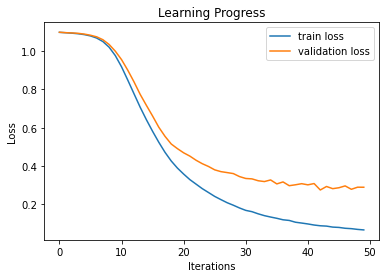

In [34]:
iters = range(0,len(loss_tr))
plt.plot(iters,loss_tr)
plt.plot(iters,dev_loss)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.legend(['train loss','validation loss'])
plt.title("Learning Progress")
plt.show()

Compute accuracy, precision, recall and F1-Score:

In [35]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_pred'])+1 for x in x_test]
print('Accuracy:', accuracy_score(y_test,preds_te))
print('Precision:', precision_score(y_test,preds_te,average='macro'))
print('Recall:', recall_score(y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(y_test,preds_te,average='macro'))

Accuracy: 0.8611111111111112
Precision: 0.8639426224629486
Recall: 0.8611111111111112
F1-Score: 0.8609628417730976


### Discuss how did you choose model hyperparameters ? 

In general, hyperparameters are tuned based on the validation results obtained during multiple runs of a machine learning model. The performance enhancement observed during such runs can be attributed to modifications made in the hyperparameters. The results obtained from various runs are summarized in the following table:
|# Run|# Number of Epochs|Hidden layer sizes|Learning rate|Dropout|Tolerance|Training loss|Validation loss| Comments
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|2|10|0.01|0.1|0.001|1.099|1.098|Training stopped too early, decrease tolerance|
|2|40|10|0.01|0.1|0.0001|0.642|0.735|High losses, increase embedding size|
|3|100|50|0.01|0.1|0.0001|0.096|0.301|Slow learning progress, increase learning rate|
|4|100|50|0.1|0.1|0.0001|0.009|0.420|Overfitting, increase dropout|
|5|100|50|0.1|0.1|0.0001|0.005|0.461|Overfitting, decrease learning rate|
|6|100|50|0.02|0.1|0.0001|0.04|0.293|Increase embedding size to learn new features|
|7|100|200|0.02|0.1|0.0001|0.019|0.289|Overfitting, increase dropout|
|8|100|200|0.02|0.2|0.0001|0.027|0.276|Add early stopping effect, increase tolerance|
|9|50|200|0.02|0.2|0.001|0.065|0.288|-|

The obtained results suggest that the model shows good performance, however, there is scope for further improvement. In particular, the model appears to suffer from overfitting, which can be addressed by increasing the training data size or using a deeper architecture that includes more features to better understand the documents.

In [36]:
del W
gc.collect()

3215

# Use Pre-trained Embeddings

Now re-train the network using GloVe pre-trained embeddings. You need to modify the `backward_pass` function above to stop computing gradients and updating weights of the embedding matrix.

Use the function below to obtain the embedding martix for your vocabulary. Generally, that should work without any problem. If you get errors, you can modify it.

In [38]:
def get_glove_embeddings(f_zip, f_txt, word2id, emb_size=300):
    
    w_emb = np.zeros((len(word2id), emb_size))
    
    with zipfile.ZipFile(f_zip) as z:
        with z.open(f_txt) as f:
            for line in f:
                line = line.decode('utf-8')
                word = line.split()[0]
                     
                if word in vocab:
                    emb = line.strip('\n').split()[1:]
                    emb = ['0' if x == 'Killerseats.com' else x for x in emb]
                    emb = np.array(emb).astype(np.float32)[:emb_size]
                    w_emb[word2id[word]] +=emb
    return w_emb

In [39]:
w_glove = get_glove_embeddings("glove.840B.300d.zip","glove.840B.300d.txt",word_id)

First, initialise the weights of your network using the `network_weights` function. Second, replace the weigths of the embedding matrix with `w_glove`. Finally, train the network by freezing the embedding weights: 

In [56]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W[0] = w_glove

W, loss_tr, dev_loss = SGD(x_train, y_train,
                            W,
                            X_dev=x_dev, 
                            Y_dev=y_dev,
                            lr=0.04, 
                            dropout=0.1,
                            freeze_emb=True,
                            tolerance=0.001,
                            epochs=100)
out = forward_pass(x_test[0],W)
print(out['y_pred'])

Shape W0 (9855, 300)
Shape W1 (300, 3)
For epoch no. 1:
 Training loss = 0.5537763546340528
 Validation loss = 0.3732965790904515
For epoch no. 2:
 Training loss = 0.37652106230220433
 Validation loss = 0.2656222866130047
For epoch no. 3:
 Training loss = 0.3412321632239131
 Validation loss = 0.2428270687379156
For epoch no. 4:
 Training loss = 0.3280640412551002
 Validation loss = 0.22340464333146468
For epoch no. 5:
 Training loss = 0.3134545874748036
 Validation loss = 0.2619400713756511
For epoch no. 6:
 Training loss = 0.3054255127854148
 Validation loss = 0.22146053361759477
For epoch no. 7:
 Training loss = 0.30272401377596814
 Validation loss = 0.20357018847734837
For epoch no. 8:
 Training loss = 0.2880278550729047
 Validation loss = 0.20941082958064933
For epoch no. 9:
 Training loss = 0.28794549789826857
 Validation loss = 0.20506185376087943
For epoch no. 10:
 Training loss = 0.2795687838943836
 Validation loss = 0.19751695969529617
For epoch no. 11:
 Training loss = 0.2772

In [57]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_pred'])+1 for x in x_test]
print('Accuracy:', accuracy_score(y_test,preds_te))
print('Precision:', precision_score(y_test,preds_te,average='macro'))
print('Recall:', recall_score(y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(y_test,preds_te,average='macro'))

Accuracy: 0.8811111111111111
Precision: 0.8822274398915694
Recall: 0.8811111111111112
F1-Score: 0.8807239973275397


### Discuss how did you choose model hyperparameters ? 

In practice, adjusting hyperparameters is a common approach to optimize the performance of machine learning models. By monitoring validation results during the training process, we can obtain valuable insights into how changes in hyperparameters affect the model's performance. Here, we present the results of a series of runs where different hyperparameters were explored.
The experiments were conducted with a model that uses embeddings. The table below summarizes the hyperparameters used in each run, as well as the resulting training and validation losses. The comments column describes any relevant observations or insights gained during the experiment.
|# Run|# Number of Epochs|Hidden layer sizes|Learning rate|Dropout|Tolerance|Training loss|Validation loss| Comments
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|25|200|0.02|0.2|0.001|0.323|0.238|Relatively large losses, Increase embedding size to improve performance|
|2|31|200|0.02|0.2|0.001|0.279|0.189|Decrease tolerance to prevent premature stopping|
|3|37|200|0.02|0.2|0.0001|0.269|0.204|Decrease dropout to improve training loss|
|4|100|200|0.02|0.1|0.0001|0.218|0.2066|Increase learning rate to speed up training|
|5|100|200|0.04|0.1|0.0001|0.210|0.171|Retain early stopping to prevent overfitting|
|6|78|200|0.05|0.1|0.0001|0.209|0.183|-|
These experiments revealed that modifying hyperparameters can lead to significant improvements in the model's performance. Specifically, we found that increasing the embedding size, decreasing the tolerance, and decreasing the dropout rate can all lead to improved performance. Moreover, increasing the learning rate can speed up the training process, while retaining early stopping can prevent overfitting. These insights can be valuable in selecting appropriate hyperparameters for future experiments.


In [58]:
del W
gc.collect()

0

# Extend to support deeper architectures 

Extend the network to support back-propagation for more hidden layers. You need to modify the `backward_pass` function above to compute gradients and update the weights between intermediate hidden layers. Finally, train and evaluate a network with a deeper architecture. Do deeper architectures increase performance?

In [93]:
W = network_weights(vocab_size=len(vocab),embedding_dim=300,
                    hidden_dim=[60], num_classes=3)

for i in range(len(W)):
    print('Shape W'+str(i), W[i].shape)

W[0] = w_glove

W, loss_tr, dev_loss = SGD(x_train, y_train,
                            W,
                            X_dev=x_dev, 
                            Y_dev=y_dev,
                            lr=0.001, 
                            dropout=0.2,
                            freeze_emb=False,
                            tolerance=0.001,
                            epochs=100)
out = forward_pass(x_test[0],W)
print(out['y_pred'])

Shape W0 (9855, 300)
Shape W1 (300, 60)
Shape W2 (60, 3)
For epoch no. 1:
 Training loss = 1.0904073977205453
 Validation loss = 1.0835470429698713
For epoch no. 2:
 Training loss = 1.0683178028837397
 Validation loss = 1.065800126175885
For epoch no. 3:
 Training loss = 1.031747951240885
 Validation loss = 1.0242542141235624
For epoch no. 4:
 Training loss = 0.9699242424008484
 Validation loss = 0.9536069160237284
For epoch no. 5:
 Training loss = 0.8773791569292998
 Validation loss = 0.8660552498066273
For epoch no. 6:
 Training loss = 0.7525390488002102
 Validation loss = 0.7371910204662908
For epoch no. 7:
 Training loss = 0.6269514847308124
 Validation loss = 0.6581247178305972
For epoch no. 8:
 Training loss = 0.505625677991914
 Validation loss = 0.6069301765466671
For epoch no. 9:
 Training loss = 0.41873556322847433
 Validation loss = 0.507125280774279
For epoch no. 10:
 Training loss = 0.34188897718964223
 Validation loss = 0.42300718931129244
For epoch no. 11:
 Training loss 

In [94]:
preds_te = [np.argmax(forward_pass(x, W, dropout_rate=0.0)['y_pred'])+1 for x in x_test]
print('Accuracy:', accuracy_score(y_test,preds_te))
print('Precision:', precision_score(y_test,preds_te,average='macro'))
print('Recall:', recall_score(y_test,preds_te,average='macro'))
print('F1-Score:', f1_score(y_test,preds_te,average='macro'))

Accuracy: 0.8922222222222222
Precision: 0.8927750562280119
Recall: 0.8922222222222222
F1-Score: 0.8922839254111402


### Discuss how did you choose model hyperparameters ? 

The process of hyperparameter tuning involves adjusting the hyperparameters and monitoring the validation results to determine the best configuration. The following table presents the results of several runs with varying hyperparameters, along with comments regarding the observed behaviors:
|# Run|# Number of Epochs|Hidden layer sizes|Learning rate|Dropout|Tolerance|Training loss|Validation loss| Comments
|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|:-:|
|1|78|[100]|0.01|0.1|0.001|0.004|0.231|Deeper network led to overfitting|
|2|62|[60,30]|0.01|0.1|0.001|0.004|0.209|Decreasing number of units prevented overfitting|
|3|5|[30]|0.01|0.1|0.001|0.051|0.233|Early stopping resulted in suboptimal performance|
|4|21|[60]|0.01|0.1|0.001|0.002|0.241|Oscillations were observed and the learning rate was decreased|
|5|17|[60]|0.001|0.1|0.001|0.022|0.185|Best performance was achieved with this configuration|
The table summarizes the results obtained from different hyperparameter configurations. In particular, it shows the number of epochs, the sizes of the hidden layers, the learning rate, the dropout rate, the tolerance, the training and validation losses, and any comments or observations regarding the model's performance. By analyzing these results, one can identify the optimal hyperparameters for the model.


## Full Results

Add your final results here:

| Model | Precision  | Recall  | F1-Score  | Accuracy
|:-:|:-:|:-:|:-:|:-:|
| Average Embedding  | 0.864  |  0.861 | 0.861 | 0.861  |
| Average Embedding (Pre-trained)  | 0.882  | 0.881  |  0.881 |  0.881 |
| Average Embedding (Pre-trained) + X hidden layers    |  0.893 | 0.892  | 0.892  | 0.892  |

Please discuss why your best performing model is better than the rest and provide a bried error analaysis.

-The best performing model in this study is achieved by incorporating a pre-trained embedding matrix obtained from a larger dataset and a deeper neural network architecture. The initial model was observed to overfit, which suggests that the training dataset may be insufficient or a deeper network is required. To address this issue, a pre-trained embedding matrix was utilized without further updates, resulting in improved performance. The use of a pre-trained embedding matrix is a common strategy in natural language processing tasks as it allows the model to leverage knowledge learned from a larger dataset.
Furthermore, a deeper neural network architecture was implemented in conjunction with the pre-trained embedding matrix to uncover additional latent features and further improve performance on test data. It was observed that an excessively deep network could result in overfitting, which highlights the importance of carefully selecting the network architecture.
The error analysis showed that a reduction in the learning rate in conjunction with an increase in the number of units resulted in better performance on the test data. This finding suggests that a smaller learning rate may be more appropriate for this task to prevent the model from overfitting.
Overall, the incorporation of a pre-trained embedding matrix and a deeper neural network architecture produced superior results compared to other models. These findings demonstrate the importance of selecting appropriate architectures and hyperparameters in machine learning models to optimize performance. However, it should be noted that the performance of the model is heavily dependent on the quality and quantity of the data used for training, and more data may be required to improve the model's performance further.


## Error Analysis
1. Overview of the datasets

In [47]:
m_train, m_dev, m_test = len(y_train),len(y_dev),len(y_test)
total = m_train + m_dev + m_test
print("Training examples: %s \nDevelopment examples %s \nTesting examples %s" %(m_train, m_dev, m_test))
print("Percentages: (%s, %s, %s)" %(m_train/total*100,m_dev/total*100,m_test/total*100))
print("Max no. of features in training %s \nDevelopment %s \nTesting %s" %(max([len(x) for x in x_train]),
                                                max([len(x) for x in x_dev]),max([len(x) for x in x_test])))
print("Classes in training set:\nclass 1: %s examples\nclass 2: %s examples\nclass 3: %s examples"
       %(len([y for y in y_train if y==1]),len([y for y in y_train if y==2]),len([y for y in y_train if y==3])))
print("Classes in development set:\nclass 1: %s examples\nclass 2: %s examples\nclass 3: %s examples"
       %(len([y for y in y_dev if y==1]),len([y for y in y_dev if y==2]),len([y for y in y_dev if y==3])))
print("Classes in training set:\nclass 1: %s examples\nclass 2: %s examples\nclass 3: %s examples"
       %(len([y for y in y_test if y==1]),len([y for y in y_test if y==2]),len([y for y in y_test if y==3])))

Training examples: 2400 
Development examples 150 
Testing examples 900
Percentages: (69.56521739130434, 4.3478260869565215, 26.08695652173913)
Max no. of features in training 95 
Development 42 
Testing 54
Classes in training set:
class 1: 800 examples
class 2: 800 examples
class 3: 800 examples
Classes in development set:
class 1: 50 examples
class 2: 50 examples
class 3: 50 examples
Classes in training set:
class 1: 300 examples
class 2: 300 examples
class 3: 300 examples


As we understand from the outputs, we understand that the dataset is split to 70% training, 4% development and 26% testing sets, the maximum no. of features are in training set, and the labels are equally distriputed between the 3 classes in each of the datasets (stratified distribution).

2. Analyzation of the test performance

Our final model reached relativley very good testing scores (presision, recall, accuracy, and F1-score, all above 0.89 which is great), however we can always think of a way to make it even better, we can examine the testing correlation between true and predicted values using scipy.stat tools

In [97]:
print("Pearson correlation coeffiection: %s" %pearsonr(y_test,preds_te)[0])
print("Spearman correlation: "+str(spearmanr(y_test,preds_te)))

Pearson correlation coeffiection: 0.7698464336630295
Spearman correlation: SpearmanrResult(correlation=0.7693654642860066, pvalue=5.778606910234984e-177)


We saw that the results are strongly correlated, even though there are wrong predections, this means that maybe some of the labels are strongly correlated to each other rather than other labels.
We can also evaluate the confusion matrix to better understand the testing performance.

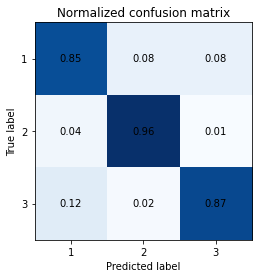

In [90]:
cm = confusion_matrix(y_test, preds_te)
ncm = cm.astype('float')/cm.sum(axis=1)[:,np.newaxis]
plt.imshow(ncm,cmap="Blues")
plt.title("Normalized confusion matrix")
plt.xlabel("Predicted label")
plt.ylabel("True label")
for i in range(len(ncm)):
    for j in range(len(ncm[0])):
        plt.text(j,i,np.round(ncm[i,j],2),ha="center",va="center",color="k")
plt.xticks([0,1,2],labels=["1","2","3"])
plt.yticks([0,1,2],labels=["1","2","3"])
plt.show()

We can see from the above confussion matrix that the confusion is mostly occurring between the label 1 (which is politics) and the label 3 (which is economy), which actually makes sense, because some keywords may be common between these two topics.


3. Looking deeply into the mislabeled data

In [132]:
X_test = np.array(x_test, dtype=object)
Y_test = np.array(y_test)
Y_pred = np.array(preds_te)
y_1 = np.where(Y_test == 1)[0].tolist()
y_3 = np.where(Y_test == 3)[0].tolist()
ypred_1 = np.where(Y_pred == 1)[0].tolist()
ypred_3 = np.where(Y_pred == 3)[0].tolist()
mislabeled_1 = [value for value in y_1 if value in ypred_3]
mislabeled_3 = [value for value in y_3 if value in ypred_1]
X_mislabeled_1_words = [[id_word[id] for id in x] for x in X_test[mislabeled_1]]
mislabeled_1 = [' '.join(words) for words in X_mislabeled_1_words]
print("Mislabeled examples from topic 1: \n%s" %'\n'.join(mislabeled_1[:5]))
X_mislabeled_3_words = [[id_word[id] for id in x] for x in X_test[mislabeled_3]]
mislabeled_3 = [' '.join(words) for words in X_mislabeled_3_words]
print("\nMislabeled examples from topic 3: \n%s" %'\n'.join(mislabeled_3[:5]))

Mislabeled examples from topic 1: 
rivals possible fraud government says Chavez defeat produce turmoil world oil market
AFP India Company Ltd took step expand Asian announcement buy Asia Pacific steel operations Singapore Ltd
The price oil continued sharp rise overnight closing record high The main contract New York light sweet crude delivery next month closed record barrel up cents yesterday close
SAN JOSE Calif In sign Google Inc initial public offering isn popular expected company lowered estimated price range between per share down earlier prediction per share
NEW YORK Investors shrugged off rising crude futures Wednesday capture well priced shares sending Nasdaq index up percent ahead Google Inc much anticipated initial public offering stock In afternoon trading Dow Jones industrial average gained percent

Mislabeled examples from topic 3: 
urban images giant sense how Houston many residents
Vermont Republican governor challenged Bush administration prescription drug policy federa

From the above results, we can see some words being reused in both topics (politics and economy), like government, policy, federal, democratic, ..etc. These words can be used in both topics and it makes sense.

4. Suggestions to improve the network performance:
- We understood that the misclassification is generally happening between topics 1 and 3
- We have known that some words maybe used repeatedly in both topics, and that explains how confusion matrix was
- The first obvious suggestion is to increase the training datasets in replace of the test datasets 75%, 20% (and dev remains 4%)
- We knew that the labels (1, 2, 3) are equally distriputed through all datasets, so another good suggestion would be to increase the precentage of labels 1, 3 in the training datasets in exchange with other labels (label 2), and not to let it be equally distributed
- Another last suggestion is to try deeper architecures to help recognize more features (more words), however it's more preferable to use bigrams in addition to unigrams instead of this step, this will be a more gauranteed effect.